# Using the expression of genes on the X-chromosome to predict young or aged cells (3/5-- model comparison)

## Outline

The **Xgene** workflow consists of four sections:

I. Exploratory data analysis (EDA) (1/5)

II. preprocessing and model tunning (2/5)

III. Model comparison (3/5, this notebook):

1. [Performance (accuracy) across 10 random states](#2.-rs)
2. [Performance (accuracy) violin plot](#3.-violin)
3. [Performance (fbeta_score -- beta=0.5, more weight to precision) violin plot](#4.-fviolin)

IV. Final model over 50 random states (4/5)

V. Results and intepretations (5/5)

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os

data_type = 'float32'

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Performance (accuracy) across 10 random states<a name="2.-rs"></a>

In [2]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, fbeta_score
from statistics import mean, stdev
import pickle

In [3]:
# load test sets
file = open('./data/test_sets.save', 'rb')
test_sets = pickle.load(file)
file.close()

In [4]:
def get_scores_acc(model, baseline=False):
    
    scores = []
    for i in range(10):
        X_test, y_test = test_sets[i]
        
        if baseline:
            scores.append(max(y_test.value_counts())/len(y_test))
        
        else:
            clf = model[i]
            y_pred = clf.predict(X_test)
            scores.append(accuracy_score(y_test, y_pred))
        
    print(f'accuracy: {mean(scores)} ± {stdev(scores)}' )
        
    return scores

In [5]:
# load linear models + knn + nb
file = open('./results/5fold_l1_models_10_finer.save', 'rb')
l1 = pickle.load(file)
file.close()

file = open('./results/5fold_l2_models_10_finer.save', 'rb')
l2 = pickle.load(file)
file.close()

file = open('./results/5fold_eln_models_10_finer.save', 'rb')
eln = pickle.load(file)
file.close()

file = open('./results/rfc_models_finer.save', 'rb')
rfc = pickle.load(file)
file.close()

file = open('./results/svc_models_finer.save', 'rb')
svc = pickle.load(file)
file.close()

file = open('./results/xgbc_models_combined.save', 'rb')
xgbc = pickle.load(file)

file = open('./results/5fold_knn_models_10.save', 'rb')
knn = pickle.load(file)
file.close()

file = open('./results/5fold_gnb_models_10.save', 'rb')
gnb = pickle.load(file)
file.close()

In [6]:
print('\nbaseline scores:')
baseline = get_scores_acc(l1, baseline=True)

print('\nl1 scores:')
l1_a = get_scores_acc(l1)

print('\nl2 scores:')
l2_a = get_scores_acc(l2)

print('\nelasticnet scores:')
eln_a = get_scores_acc(eln)

print('\nknn scores:')
knn_a = get_scores_acc(knn)

print('\nnaive bayes scores:')
gnb_a = get_scores_acc(gnb)

print('\nrfc scores:')
rfc_a = get_scores_acc(rfc)

print('\nsvc scores:')
svc_a = get_scores_acc(svc)

print('\nxgbc scores:')
xgbc_a = get_scores_acc(xgbc)


baseline scores:
accuracy: 0.5968606278744251 ± 0.006167108692998895

l1 scores:
accuracy: 0.7325734853029394 ± 0.006373815650172168

l2 scores:
accuracy: 0.732873425314937 ± 0.006094644878193586

elasticnet scores:
accuracy: 0.7330333933213358 ± 0.006337642297194956

knn scores:
accuracy: 0.6337732453509298 ± 0.007183887772449416

naive bayes scores:
accuracy: 0.640631873625275 ± 0.012261243043684785

rfc scores:
accuracy: 0.7607878424315138 ± 0.007867945667678367

svc scores:
accuracy: 0.7509098180363927 ± 0.007558646999092589

xgbc scores:
accuracy: 0.7690861827634473 ± 0.006860956535557812


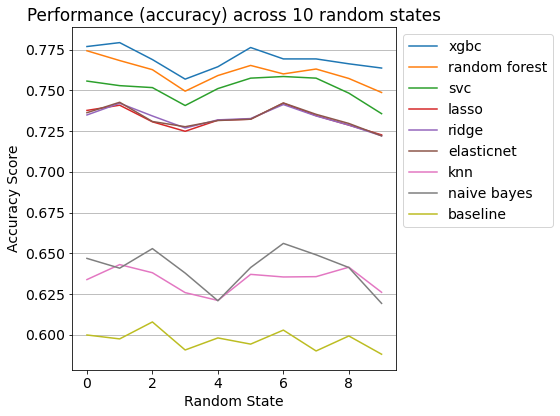

In [7]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))

plt.plot(xgbc_a, label="xgbc")
plt.plot(rfc_a, label="random forest")
plt.plot(svc_a, label="svc")

plt.plot(l1_a, label="lasso")
plt.plot(l2_a, label="ridge")
plt.plot(eln_a, label="elasticnet")

plt.plot(knn_a, label="knn")
plt.plot(gnb_a, label="naive bayes")

plt.plot(baseline, label="baseline")

plt.grid(axis='y')
plt.title("Performance (accuracy) across 10 random states")
plt.xlabel("Random State")
plt.ylabel("Accuracy Score")
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('./figures/models_10.pdf')
plt.show()

## 2) Performance (accuracy)  violin plot<a name="3.-violin"></a>

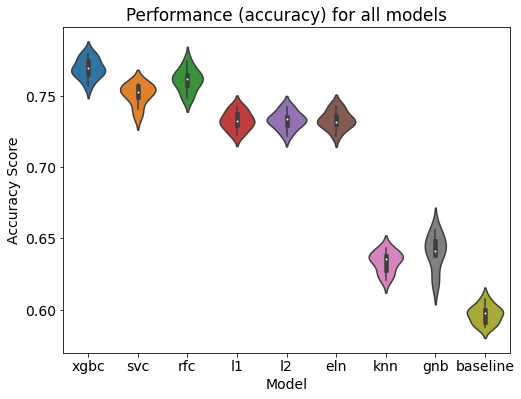

In [8]:
df = {'xgbc': xgbc_a,
      'svc': svc_a,
      'rfc': rfc_a,
      'l1': l1_a,
      'l2': l2_a,
      'eln': eln_a,
      'knn': knn_a,
      'gnb': gnb_a,
      'baseline': baseline}

df = pd.DataFrame(df)

plt.figure(figsize=(8,6))

sns.violinplot(data=df)
plt.title('Performance (accuracy) for all models')
plt.xlabel("Model")
plt.ylabel("Accuracy Score")
plt.savefig('./figures/models_violin_acc.pdf')
plt.show()

## 3) Performance (fbeta_score -- beta=0.5, more weight to precision) violin plot<a name="4.-fviolin"></a>

In [9]:
def get_scores_f(model, baseline=False):
    
    scores = []
    for i in range(10):
        X_test, y_test = test_sets[i]
        
        # baseline: dummy predictor that always predict 1
        if baseline:
            y_dummy = y_test.copy()
            y_dummy[:] = 1
            scores.append(fbeta_score(y_test, y_dummy, beta=0.5))
        
        else:
            clf = model[i]
            y_pred = clf.predict(X_test)
            scores.append(fbeta_score(y_test, y_pred, beta=0.5))
        
    print(f'f_0.5 score: {mean(scores)} ± {stdev(scores)}' )
        
    return scores

In [10]:
print('\nbaseline scores:')
baseline_f = get_scores_f(l1, baseline=True)

print('\nl1 scores:')
l1_f = get_scores_f(l1)

print('\nl2 scores:')
l2_f = get_scores_f(l2)

print('\nelasticnet scores:')
eln_f = get_scores_f(eln)

print('\nknn scores:')
knn_f = get_scores_f(knn)

print('\nnaive bayes scores:')
gnb_f = get_scores_f(gnb)

print('\nrfc scores:')
rfc_f = get_scores_f(rfc)

print('\nsvc scores:')
svc_f = get_scores_f(svc)

print('\nxgbc scores:')
xgbc_f = get_scores_f(xgbc)


baseline scores:
f_0.5 score: 0.6491975699509465 ± 0.005835686804183588

l1 scores:
f_0.5 score: 0.7618502137903391 ± 0.007325717886598455

l2 scores:
f_0.5 score: 0.7624863448620719 ± 0.007448497368565996

elasticnet scores:
f_0.5 score: 0.7622812117357496 ± 0.007206437701696984

knn scores:
f_0.5 score: 0.6772830252356743 ± 0.006827580410138858

naive bayes scores:
f_0.5 score: 0.687774135124659 ± 0.013486174826892239

rfc scores:
f_0.5 score: 0.7911246797223732 ± 0.0092527336659933

svc scores:
f_0.5 score: 0.7758841790641243 ± 0.008554644470372982

xgbc scores:
f_0.5 score: 0.7969300919064319 ± 0.007606862159138656


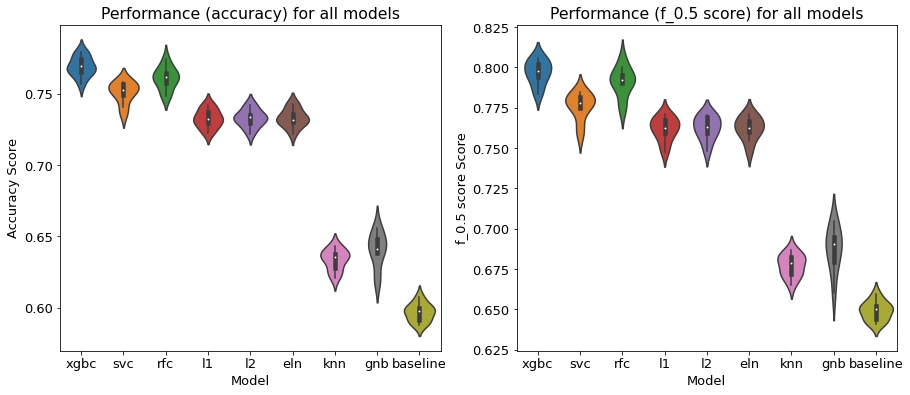

In [11]:
df_f = {'xgbc': xgbc_f,
      'svc': svc_f,
      'rfc': rfc_f,
      'l1': l1_f,
      'l2': l2_f,
      'eln': eln_f,
      'knn': knn_f,
      'gnb': gnb_f,
      'baseline': baseline_f}



df_f = pd.DataFrame(df_f)

plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
sns.violinplot(data=df)
plt.title('Performance (accuracy) for all models')
plt.xlabel("Model")
plt.ylabel("Accuracy Score")
plt.savefig('./figures/models_violin_acc.pdf')

plt.subplot(1, 2, 2)
sns.violinplot(data=df_f)
plt.title('Performance (f_0.5 score) for all models')
plt.xlabel("Model")
plt.ylabel("f_0.5 score Score")
plt.savefig('./figures/models_violin_f.pdf')
plt.show()